In [2]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [4]:
import cv2
import numpy as np
import pandas as pd
from pathgan.utils import rgb2binary
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image, ImageDraw
import os
import re
import glob
import sys
from  pathlib import Path
from collections import deque
from pathgan.models.rrt import RRT

In [2]:
dataset_path = 'data/generated_dataset/dataset/'
data_path = 'data/generated_dataset/'

In [3]:
roi_result_list = glob.glob(dataset_path + 'results/*.png')
roi_result_list.sort(key = lambda s: int(re.search('\d+', s).group()))
roi_result_list[:3]

['./PathGAN/data/dataset/results\\roi_0.png',
 './PathGAN/data/dataset/results\\roi_1.png',
 './PathGAN/data/dataset/results\\roi_2.png']

In [46]:
data = pd.read_csv(dataset_path + 'results/results.csv')
data = data.sort_values(by="true_roi").reset_index(drop=True)
data.head()

,true_roi,pred_roi,iou,fid,is,dice
0,dataset/tasks/map_0/task_2_roi.png,results/roi_219.png,0.714286,44.443390,1.019218,0.833333
1,dataset/tasks/map_0/task_30_roi.png,results/roi_1410.png,0.655098,113.003944,1.019218,0.791612
2,dataset/tasks/map_0/task_32_roi.png,results/roi_1219.png,0.773879,80.301636,1.019218,0.872527
3,dataset/tasks/map_0/task_35_roi.png,results/roi_644.png,0.683135,69.818451,1.019218,0.811741
4,dataset/tasks/map_0/task_36_roi.png,results/roi_1972.png,0.724816,113.334282,1.019218,0.840456


In [5]:
#print(os.path.basename(your_path))
os.path.dirname('dataset/tasks/map_84/task_99_roi.png')

'dataset/tasks/map_84'

In [6]:
data.true_roi[0]

'dataset/tasks/map_0/task_2_roi.png'

In [7]:
#re.search('.*\/map\_(\d+)', data.true_roi[0]).group()
#ouput 'dataset/tasks/map_0'
map_file = os.path.dirname(data.true_roi[0])
map_file

'dataset/tasks/map_0'

In [8]:
Tasks = pd.read_csv(data_path + map_file + '.csv')
Tasks.head(3)

,istart,jstart,igoal,jgoal,euclid
0,42,30,56,1,32.202484
1,2,12,34,62,59.363288
2,15,56,40,38,30.805844


In [9]:
task_num = int(re.search('task\_(\d+)', os.path.basename(data.true_roi[0])).group(1))
task_num

2

In [10]:
start = (Tasks.istart[task_num], Tasks.jstart[task_num])
goal = (Tasks.igoal[task_num], Tasks.jgoal[task_num])

In [11]:
colors = {'start': np.array([0, 0, 1]), 'goal': np.array([1, 0, 0]), 'roi': np.array([0, 1, 0])}

In [12]:
Map = re.search('map\_(\d+)', data.true_roi[0]).group(0)
Map

'map_0'

In [13]:
Map_img = Image.open( dataset_path + 'maps/' + Map + '.png').convert('RGB')

In [14]:
true_roi = Image.open(data_path + data.true_roi[0]).convert('RGB')

In [15]:
pred_roi = Image.open(dataset_path + data.pred_roi[0]).convert('RGB')

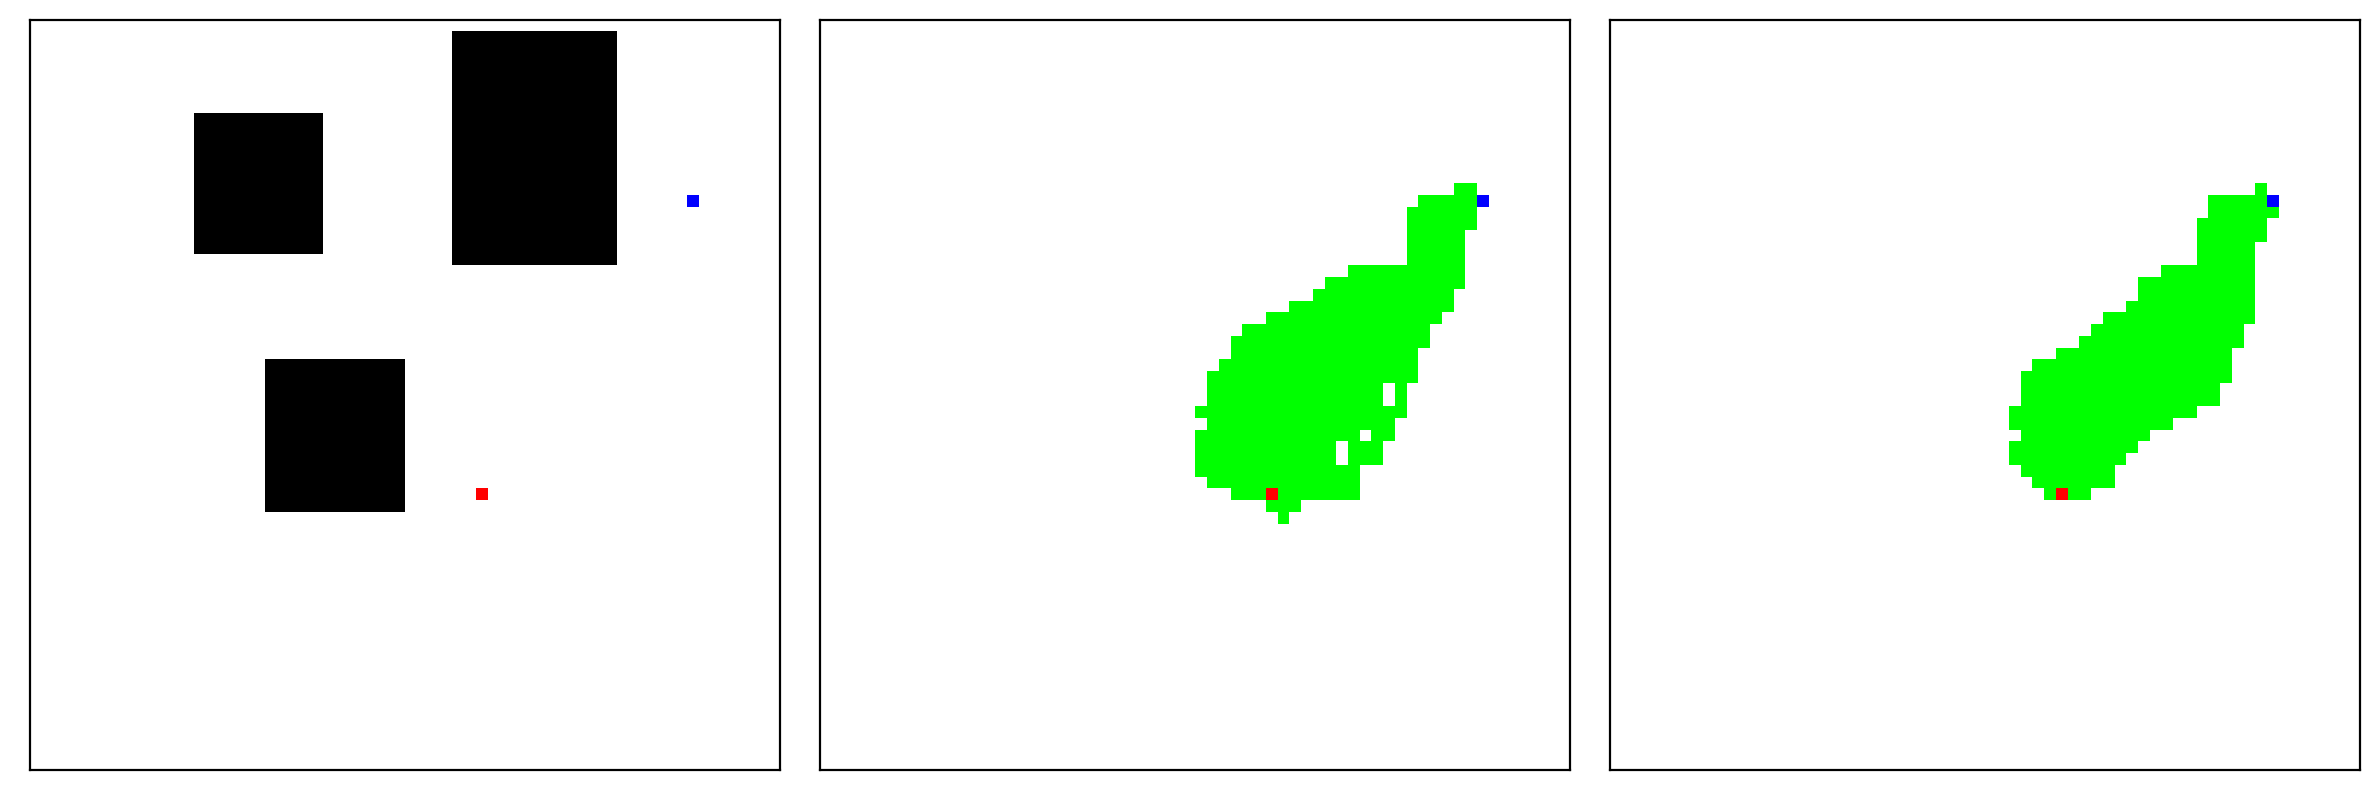

In [16]:
fig, ax = plt.subplots(ncols=3,  figsize=(12, 10), dpi=200)
for axx, map_img in zip(ax.flatten(), [Map_img, true_roi, pred_roi]):
    k = map_img.load()
    k[int(start[1]), int(start[0])] = tuple(colors['start']*255)
    k[int(goal[1]), int(goal[0])] = tuple(colors['goal']*255)
    
    axx.axes.xaxis.set_visible(False)
    axx.axes.yaxis.set_visible(False)
    axx.imshow(map_img);
plt.tight_layout()

In [17]:
pred_roi = Image.open(dataset_path + data.pred_roi[0]).convert('RGB')
mask_grid = rgb2binary(np.array(pred_roi))
mask_grid = np.where(np.sum(mask_grid, axis=2) > 2, 0, 1)

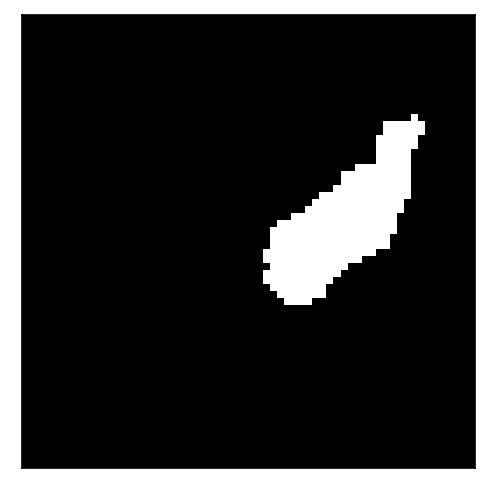

In [18]:
fig, ax = plt.subplots(dpi=150)
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.imshow(mask_grid, cmap='gray');

In [19]:
model = RRT()

In [20]:
path = model.search(mask_grid, start, goal,  func='cdist')

In [21]:
path

[(40, 38),
 (39, 38),
 (35, 37),
 (33, 34),
 (30, 37),
 (29, 41),
 (28, 45),
 (26, 48),
 (22, 50),
 (18, 50),
 (15, 52),
 (15, 56)]

In [22]:
def IsPathFound(index, mod=model):
    map_file = os.path.dirname(data.true_roi.values[index])
    Tasks = pd.read_csv(data_path + map_file + '.csv')
    
    task_num = int(re.search('task\_(\d+)', os.path.basename(data.true_roi.values[index])).group(1))
    start = (Tasks.istart[task_num], Tasks.jstart[task_num])
    goal = (Tasks.igoal[task_num], Tasks.jgoal[task_num])
    
    pred_roi = rgb2binary(np.array(Image.open(dataset_path + data.pred_roi[index]).convert('RGB')))
    
    if any(pred_roi[int(start[0]), int(start[1])] != colors.get('roi')):
        pred_roi[int(start[0]), int(start[1])] = colors.get('roi')

    if any(pred_roi[int(goal[0]), int(goal[1])] != colors.get('roi')):
        pred_roi[int(goal[0]), int(goal[1])] = colors.get('roi')
    
    mask_grid = np.where(np.sum(pred_roi, axis=2) > 2, 0, 1)
    path = mod.search(mask_grid, start, goal, max_iter=40_000, func='cdist')
    
    return 1 if path else 0
    

In [23]:
r = [IsPathFound(i) for i in tqdm(range(2000))]

In [24]:
np.sum(r)

1315

In [48]:
data.insert(6, 'is_path_found', r)
data.to_csv(dataset_path + 'results/results_total.csv')

### MovingAI

In [25]:
dataset_path = './PathGAN/data/dataset/'
data_path = './PathGAN/data//dataset/' 

In [26]:
data = pd.read_csv(dataset_path + 'movingai/results/results.csv')
data = data.sort_values(by="true_roi").reset_index(drop=True)
data.head()

,true_roi,pred_roi,iou,dice,fid,is
0,movingai\tasks\Aftershock_1\task_0_roi.png,movingai\results\roi_0.png,0.595349,0.746356,79.160278,1.013548
1,movingai\tasks\Aftershock_1\task_1_roi.png,movingai\results\roi_1.png,0.482440,0.650873,66.227379,1.013548
2,movingai\tasks\Aftershock_1\task_2_roi.png,movingai\results\roi_2.png,0.543919,0.704595,83.625259,1.013548
3,movingai\tasks\Aftershock_1\task_3_roi.png,movingai\results\roi_3.png,0.553163,0.712305,102.917053,1.013548
4,movingai\tasks\Aftershock_1\task_4_roi.png,movingai\results\roi_4.png,0.537477,0.699168,77.991684,1.013548


In [27]:
data.true_roi.values.shape

(699,)

In [28]:
map_file = os.path.dirname(data.true_roi.values[0])
Tasks = pd.read_csv(data_path + map_file + '.csv')

#Map = re.search('\w*\_(\d+)', data.true_roi.values[0]).group(0)
Map_img = Image.open( dataset_path + map_file.replace('tasks', 'maps') + '.png').convert('RGB')

In [29]:
task_num = int(re.search('task\_(\d+)', os.path.basename(data.true_roi.values[0])).group(1))
start = (Tasks.istart[task_num], Tasks.jstart[task_num])
goal = (Tasks.igoal[task_num], Tasks.jgoal[task_num])

In [30]:
pred_roi = rgb2binary(np.array(Image.open(dataset_path + data.pred_roi[0]).convert('RGB')))

if any(pred_roi[int(start[0]), int(start[1])] != colors.get('roi')):
    pred_roi[int(start[0]), int(start[1])] = colors.get('roi')

if any(pred_roi[int(goal[0]), int(goal[1])] != colors.get('roi')):
    pred_roi[int(goal[0]), int(goal[1])] = colors.get('roi')

In [31]:
mask_grid = np.where(np.sum(pred_roi, axis=2) > 2, 0, 1)
path = model.search(mask_grid, start, goal, max_iter=40_000, func='cdist')

In [32]:
path

[(52, 17),
 (48, 16),
 (46, 19),
 (43, 22),
 (42, 26),
 (38, 25),
 (36, 29),
 (34, 32),
 (34, 36),
 (32, 40),
 (28, 39),
 (24, 41),
 (22, 44),
 (18, 45),
 (14, 45),
 (12, 48),
 (9, 51),
 (9, 55)]

In [33]:
r1 = [IsPathFound(i) for i in tqdm(range(699))]

In [34]:
np.sum(r1)

381

In [35]:
381/699

0.5450643776824035

In [42]:
data.insert(6, 'is_path_found', r1)

In [43]:
data

,true_roi,pred_roi,iou,dice,fid,is,is_path_found
0,movingai\tasks\Aftershock_1\task_0_roi.png,movingai\results\roi_0.png,0.595349,0.746356,79.160278,1.013548,1
1,movingai\tasks\Aftershock_1\task_1_roi.png,movingai\results\roi_1.png,0.482440,0.650873,66.227379,1.013548,1
2,movingai\tasks\Aftershock_1\task_2_roi.png,movingai\results\roi_2.png,0.543919,0.704595,83.625259,1.013548,0
3,movingai\tasks\Aftershock_1\task_3_roi.png,movingai\results\roi_3.png,0.553163,0.712305,102.917053,1.013548,1
4,movingai\tasks\Aftershock_1\task_4_roi.png,movingai\results\roi_4.png,0.537477,0.699168,77.991684,1.013548,1
...,...,...,...,...,...,...,...
694,movingai\tasks\tranquilpaths_100\task_5_roi.png,movingai\results\roi_657.png,0.245232,0.393873,110.672363,1.013548,0
695,movingai\tasks\tranquilpaths_100\task_6_roi.png,movingai\results\roi_658.png,0.408898,0.580451,54.585545,1.013548,0
696,movingai\tasks\tranquilpaths_100\task_7_roi.png,movingai\results\roi_659.png,0.347909,0.516220,72.645424,1.013548,1
697,movingai\tasks\tranquilpaths_100\task_8_roi.png,movingai\results\roi_660.png,0.394030,0.565310,55.725967,1.013548,0


In [45]:
data.to_csv(dataset_path + 'movingai/results/results_total.csv')